[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mariyamuneeb/ssl_wordspotting/blob/main/VariationalAE.ipynb)

## Project Setup

In [1]:
import os
!git clone https://github.com/mariyamuneeb/ssl_wordspotting
os.chdir('/content/ssl_wordspotting')
!pip install -qqq wandb

from setup_wandb import wandb_login
wandb_login()

Cloning into 'ssl_wordspotting'...
remote: Enumerating objects: 297, done.
remote: Counting objects: 100% (16/16), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 297 (delta 4), reused 10 (delta 4), pack-reused 281
Receiving objects: 100% (297/297), 8.87 MiB | 9.02 MiB/s, done.
Resolving deltas: 100% (160/160), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 73.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 KB 18.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 KB 23.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 8.2 MB/s eta 0:00:00
/content/ssl_wordspotting
Mounted at /content/drive
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [2]:
import torch

In [3]:
import matplotlib.pyplot as plt # plotting library
import numpy as np # this module is useful to work with numerical arrays
import pandas as pd 
import random 
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader,random_split
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import wandb
import numpy as np
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Standard Datasets

## Initialization

In [ ]:
num_channels = 3
base_channel_size=32
lr = 10e-2
latent_dim = 384
epochs = 300
plot_freq = 10

wandb.init(
      # Set the project where this run will be logged
      project="SSL", 
      # We pass a run name (otherwise it’ll be randomly assigned, like sunshine-lollypop-10)
      name=f"VAE", 
      # Track hyperparameters and run metadata
      config={
      "architecture": "CNN",
      "dataset": "CIFAR-10",
      "epochs": epochs,
      "latent_dim":latent_dim
      })

In [ ]:
torch.manual_seed(0)

# d = 4

vae = VariationalAutoencoder(latent_dims=4)

optim = torch.optim.Adam(vae.parameters(), lr=lr)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

vae.to(device)

## Import/Load Datasets

In [ ]:
data_dir = 'dataset'
# train_dataset = torchvision.datasets.MNIST(data_dir, train = True, download = True)
# test_dataset  = torchvision.datasets.MNIST(data_dir, train=False, download=True)

train_dataset = torchvision.datasets.CIFAR10(data_dir,train=True,download=True)
test_dataset  = torchvision.datasets.CIFAR10(data_dir,train=False, download=True)

In [ ]:
img = train_dataset[1][0]
label = train_dataset[1][1]
print(img.mode)
print(label)
plt.imshow(img)
plt.show()

In [ ]:
img.size

In [ ]:
train_transform = transforms.Compose([transforms.ToTensor(), ])

test_transform = transforms.Compose([transforms.ToTensor(), ])

In [ ]:
train_dataset.transform = train_transform
test_dataset.transform = test_transform

m=len(train_dataset)

train_data, val_data = random_split(train_dataset, [int(m-m*0.2), int(m*0.2)])
batch_size=256

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
valid_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,shuffle=True)

VariationalAutoencoder class, which combines the Encoder and Decoder classes 
The encoder and decoder networks contain **three convolutional layers** and **two fully connected layers**. 
Some batch normal layers are added to have more robust features in the latent space. 
Differently from the standard autoencoder, the **encoder returns mean and variance matrices** and we use them to obtain the sampled latent vector. 

## Training Loop

In [ ]:
for epoch in range(epochs):
   train_loss = train_epoch(vae,device,train_loader,optim)
   val_loss = test_epoch(vae,device,valid_loader)
   print('\n EPOCH {}/{} \t train loss {:.3f} \t val loss {:.3f}'.format(epoch + 1, epochs,train_loss,val_loss))
   if epoch%plot_freq==0:
       plot_ae_outputs(vae.encoder,vae.decoder,n=10)

In [ ]:
break

In [ ]:
train_loader

# VAE on Hand-written Dataset 

## Dataset

### Connect to GDrive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
PATH = '/content/drive/MyDrive/Datasets/tif'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Imports

In [ ]:
import os
import cv2
import math
from PIL import Image
import matplotlib.pyplot as plt
from statistics import mean
from math import floor

### Custom Dataset Definition

In [ ]:
images_paths = [os.path.join(PATH,i) for i in os.listdir(PATH)]
split = 0.85
train_idx = math.floor(split*len(images_paths))
train_images = images_paths[:train_idx]
test_images = images_paths[train_idx:]

### Plotting Few Images

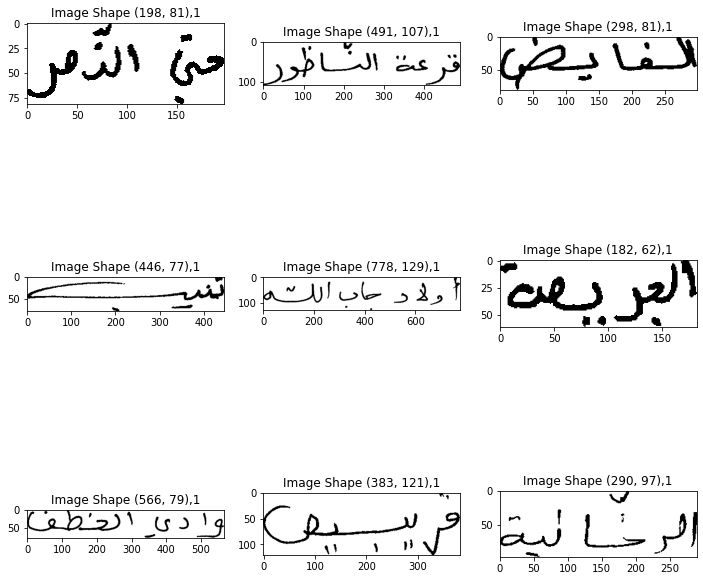

In [ ]:
random_imgs = random.sample(train_images, 9)
random_imgs = [Image.open(i) for i in random_imgs]
_, axs = plt.subplots(3, 3, figsize=(12, 12))
axs = axs.flatten()
for img, ax in zip(random_imgs, axs):
    ax.imshow(img)
    ax.title.set_text(f'Image Shape {img.size},{img.mode}')
plt.show()

### Finding Ave Image Dimensions

In [ ]:
h_list = list()
w_list = list()

for p in train_images:
    h_list.append(Image.open(p).size[1])
    w_list.append(Image.open(p).size[0])
num_channels = int(Image.open(p).mode)

h_ave = floor(mean(h_list))
w_ave = floor(mean(w_list))
# resize_size = (h_ave,w_ave)
resize_size = (128,128)

### Dataset Definitions

In [ ]:
train_transform = transforms.Compose([transforms.ToTensor(),
                                      transforms.Resize(resize_size),])
test_transform = transforms.Compose([transforms.ToTensor(),
                                     transforms.Resize(resize_size),])

hw_train_dataset = MyDataset(img_paths=train_images,transform=train_transform)
hw_test_dataset = MyDataset(img_paths=test_images,transform=test_transform)

NameError: ignored

### Dataloader and Batching Definitions

In [ ]:
m=len(hw_train_dataset)


batch_size=8

train_loader = torch.utils.data.DataLoader(hw_train_dataset, batch_size=batch_size)
valid_loader = torch.utils.data.DataLoader(hw_test_dataset, batch_size=batch_size)

## Plotting

## Initialization

### Hyperparameters

In [ ]:
base_channel_size = 32
lr = 1e-3
latent_dim = 512
epochs = 300
plot_freq = 10

In [ ]:
hw_train_dataset[0][0].shape

### W&B Init

In [ ]:
wandb.init(
      # Set the project where this run will be logged
      project="SSL", 
      # We pass a run name (otherwise it’ll be randomly assigned, like sunshine-lollypop-10)
      name=f"VAE", 
      # Track hyperparameters and run metadata
      config={
      "architecture": "CNN",
      "dataset": "Hand Written Dataset",
      "lr":lr,
      "epochs": epochs,
      "latent_dim":latent_dim
      })

### Initialize VAE

Initialize the VariationalAutoencoder class, the optimizer, and the device to use the GPU in the code.

In [ ]:
torch.manual_seed(0)

vae = VariationalAutoencoder(num_channels,base_channel_size,latent_dim)
print(vae)

optim = torch.optim.Adam(vae.parameters(), lr=lr)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')
vae.to(device)

## Training

### Train Loop

In [ ]:
for epoch in range(epochs):
   train_loss = train_epoch(vae,device,train_loader,optim)
   val_loss = test_epoch(vae,device,valid_loader)
   print('\n EPOCH {}/{} \t train loss {:.3f} \t val loss {:.3f}'.format(epoch + 1, epochs,train_loss,val_loss))
   if epoch%plot_freq==0:
       plot_ae_custom_ds_outputs(vae.encoder,vae.decoder,hw_test_dataset,n=10)

# IAM Dataset


## Dataset

In [4]:
from models.dataset_utils import IAMDataset2,IAMDataset,IAMSubset
from models.layers import VariationalEncoder,Decoder
from experiment_utils.utils import train_epoch,test_epoch
from PIL import Image
from math import floor
from statistics import mean

### Copy Dataset to Colab Instance

In [7]:
from data_utils.utils import copy_iam_dataset_to_colab
copy_iam_dataset_to_colab()

Copying IAM Dataset from GDrive
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/ssl_wordspotting/data/IAM_HW/words.tgz now copied
/content/ssl_wordspotting/data/IAM_HW/xml.tgz now copied
/content/ssl_wordspotting/data/IAM_HW/rules.zip now copied
Copied IAM HW Files


In [ ]:
# train_dir = '/content/ssl_wordspotting/data/words_training'
# test_dir = '/content/ssl_wordspotting/data/words_test'

In [8]:
resize_size = (128,128)
train_transform = transforms.Compose([transforms.ToTensor(),
                                      transforms.Resize(resize_size),])
test_transform = transforms.Compose([transforms.ToTensor(),
                                     transforms.Resize(resize_size),])
iam_train_dataset = IAMDataset2('train',transform=train_transform)
iam_test_dataset = IAMDataset2('test',transform=train_transform)


In [7]:
subset_iam_train_dataset = IAMSubset().subset(iam_train_dataset,0.2)
subset_iam_test_dataset = IAMSubset().subset(iam_test_dataset,0.2)

### Plot Few Samples

In [ ]:
from data_utils.plotting import plot_iam_samples,plot_reconstructions,plot_iam_reconstructions
# plot_iam_samples(iam_train_dataset,9)

In [9]:
batch_size=256

train_loader = torch.utils.data.DataLoader(iam_train_dataset, batch_size=batch_size)
valid_loader = torch.utils.data.DataLoader(iam_test_dataset, batch_size=batch_size)

## Initialization

### HyperParameters

In [ ]:
base_channel_size = 32
num_channels = 3
lr = 1e-3
latent_dim = 512
epochs = 150
plot_freq = 10

### W&B Init

In [ ]:
wandb.init(
      # Set the project where this run will be logged
      project="SSL", 
      # We pass a run name (otherwise it’ll be randomly assigned, like sunshine-lollypop-10)
      name=f"IAM VAE", 
      # Track hyperparameters and run metadata
      config={
      "architecture": "CNN",
      "dataset": "IAM Hand Written Dataset",
      "lr":lr,
      "epochs": epochs,
      "latent_dim":latent_dim
      })

### Define VAE

In [ ]:
class VariationalAutoencoder(nn.Module):
    def __init__(self, num_channels, base_channel_size, latent_dim):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = VariationalEncoder(num_channels, base_channel_size, latent_dim)
        self.decoder = Decoder(num_channels, base_channel_size, latent_dim)

    def forward(self, x):
        x = x.to(device)
        z = self.encoder(x)
        return self.decoder(z)

### Initialize VAE

In [ ]:
torch.manual_seed(0)

vae = VariationalAutoencoder(num_channels,base_channel_size,latent_dim)

vae.to(device)
optim = torch.optim.Adam(vae.parameters(), lr=lr)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')


Selected device: cuda


## Training

### Train Loop

In [ ]:
for epoch in range(epochs):
   train_loss = train_epoch(vae,device,train_loader,optim)
   val_loss = test_epoch(vae,device,valid_loader)
   print('\n EPOCH {}/{} \t train loss {:.3f} \t val loss {:.3f}'.format(epoch + 1, epochs,train_loss,val_loss))
   if epoch%plot_freq==0:
       plot_reconstructions(vae.encoder,vae.decoder,iam_test_dataset,device, n=10)
       

RuntimeError: ignored

In [ ]:
device

## Initialization

### HyperParameters

In [8]:
base_channel_size = 32
num_channels = 1
lr = 1e-3
latent_dim = 512
epochs = 20
plot_freq = 10

### W&B Init

In [9]:
wandb.init(
      # Set the project where this run will be logged
      project="SSL", 
      # We pass a run name (otherwise it’ll be randomly assigned, like sunshine-lollypop-10)
      name=f"IAM VAE", 
      # Track hyperparameters and run metadata
      config={
      "architecture": "CNN",
      "dataset": "IAM Hand Written Dataset",
      "lr":lr,
      "epochs": epochs,
      "latent_dim":latent_dim
      })

wandb: Currently logged in as: mariyamuneeb. Use `wandb login --relogin` to force relogin


### Define VAE

In [10]:
class VariationalAutoencoder(nn.Module):
    def __init__(self, num_channels, base_channel_size, latent_dim):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = VariationalEncoder(num_channels, base_channel_size, latent_dim)
        self.decoder = Decoder(num_channels, base_channel_size, latent_dim)

    def forward(self, x):
        x = x.to(device)
        z = self.encoder(x)
        return self.decoder(z)

### Initialize VAE

In [11]:
torch.manual_seed(0)

vae = VariationalAutoencoder(num_channels,base_channel_size,latent_dim)

vae.to(device)
optim = torch.optim.Adam(vae.parameters(), lr=lr)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')


Selected device: cuda


## Training

### Train Loop

In [15]:
for epoch in range(epochs):
    try:
        train_loss = train_epoch(vae,device,train_loader,optim)
    except Exception as e:
        print(e)
    val_loss = test_epoch(vae,device,valid_loader)
    
    print('\n EPOCH {}/{} \t train loss {:.3f} \t val loss {:.3f}'.format(epoch + 1, epochs,train_loss,val_loss))
    if epoch%plot_freq==0:
        plot_iam_reconstructions(vae.encoder,vae.decoder,iam_test_dataset,device,'IAM HW', n=10)
        
        ## save model here
        ## run evaluation of MAP

cannot identify image file '/content/ssl_wordspotting/data/IAM_HW/words/a01/a01-117/a01-117-05-02.png'
local variable 'img' referenced before assignment


KeyboardInterrupt: ignored

In [28]:
ouput = vae.encoder(next(iter(valid_loader))[1].to('cuda'))
# output = vae.encoder(test_loader[0][1].to('cuda'))

In [37]:
ouput[0].data.cpu().numpy().flatten().shape

(512,)

In [ ]:
PATH = '/content/drive/MyDrive/Mariyah_Phd/weights/vae_weights.pt'
torch.save(model, PATH)

NameError: ignored

In [ ]:
!pwd

/content/ssl_wordspotting


In [ ]:
def plot_iam_reconstructions(encoder, decoder, test_dataset, device, dataset_name, n=10):
    wandb_imgs = list()
    wandb_rec_imgs = list()
    my_table = wandb.Table(columns=["Original", "Reconstruction"])
    plt.figure(figsize=(16, 4.5))
    for i in range(n):
        ax = plt.subplot(2, n, i + 1)
        _, img, _ = test_dataset[i]
        img = img.unsqueeze(0).to(device)
        encoder.eval()
        decoder.eval()
        with torch.no_grad():
            rec_img = decoder(encoder(img))
        plt.imshow(img.cpu().squeeze().numpy().T, cmap='gist_gray')  # for MNIST remove the transpose
        #   plt.imshow(img.cpu().squeeze().numpy(), cmap='gist_gray') # for MNIST remove the transpose
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i == n // 2:
            ax.set_title('Original images')
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(rec_img.cpu().squeeze().numpy().T, cmap='gist_gray')  # for MNIST remove the transpose
        #   plt.imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')  #for MNIST remove the transpose
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i == n // 2:
            ax.set_title('Reconstructed images')
        my_table.add_data(wandb.Image(img.cpu()), wandb.Image(rec_img.cpu()))
        wandb_imgs.append(img.cpu())
        wandb_rec_imgs.append(rec_img.cpu())
    plt.show()
    wandb.log({dataset_name: my_table})

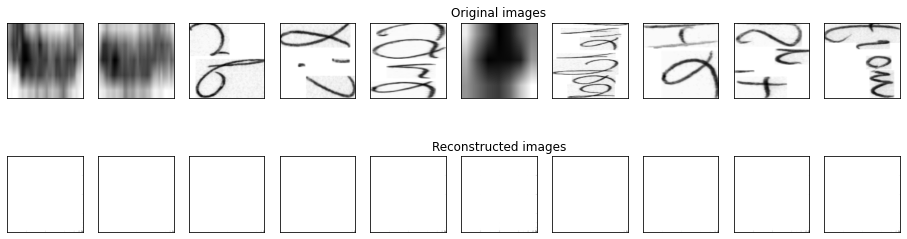

In [ ]:
plot_iam_reconstructions(vae.encoder,vae.decoder,subset_iam_test_dataset,device,'IAM HW', n=10)

In [5]:
import pathlib
# import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader, Subset
import os
from PIL import Image, UnidentifiedImageError
import random
# import pathlib
import logging
from paths import IAM_XML_DIR, IAM_DIR, IAM_RULE_DIR, IAM_WORDS_DIR
from xml.etree import ElementTree as ET
from datetime import datetime
import numpy as np
import glob

In [6]:
class IAMDataset2(Dataset):
    def __init__(self, ttype, transform=None):
        self.label_encoder = None
        self.transform = transform
        self.ttype = ttype
        if ttype == 'train':
            self.rule_file_path = IAM_RULE_DIR / "trainset.txt"
        elif ttype == 'test':
            self.rule_file_path = IAM_RULE_DIR / "testset.txt"
        elif ttype == 'val':
            self.rule_file_path = IAM_RULE_DIR / "validationset1.txt"
        self.line_folders = None
        self.line_folders, self.line_dirs = self.create_line_dirs()
        self.samples, self.labels = self.get_word_labels()
        self.labels_encoder()

    def unique_word_labels(self):
        labels = list(set(self.labels))
        return labels

    def labels_encoder(self):
        labels = self.unique_word_labels()
        self.label_encoder = LabelEncoder()
        self.label_encoder.fit(labels)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_id, img_path, label = self.samples[idx]
        encoded_label = self.label_encoder.transform([label])
        img = Image.open(img_path)
        if self.transform:
            img = self.transform(img)
        return img_id, img, label, encoded_label[0]

    def get_xml_file_object(self, path):
        tree = ET.parse(path)
        root = tree.getroot()
        return root

    def get_word_labels(self):
        word_ids, word_paths = self.get_words()

        word_ids, xml_paths = self.construct_xml_file_paths(word_ids)
        ll = list()
        labels = list()
        for word_id, word_path, xml_path in zip(word_ids, word_paths, xml_paths):
            root = self.get_xml_file_object(xml_path)
            for word in root.iter('word'):
                img_id = word.get('id')
                if img_id == word_id:
                    label = word.get('text')
                    ll.append((word_id, word_path, label))
                    labels.append(label)

        return ll, labels

    def construct_xml_file_paths(self, word_ids):
        xml_paths = ['-'.join(i.split('-')[:-2]) + '.xml' for i in word_ids]
        xml_paths = [IAM_XML_DIR / i for i in xml_paths]
        return word_ids, xml_paths

    def get_words(self):
        # print(len(sample_group_dir))

        image_paths = [glob.glob(f"{i}/*.png") for i in self.line_dirs]
        # print(sample_file_paths)

        image_paths = [item for sublist in image_paths for item in sublist]

        line_ids = self.read_line_ids()

        word_paths = [i for i in image_paths if '-'.join(pathlib.Path(i).name.split('-')[:-1])
                      in line_ids]
        word_ids = [pathlib.Path(i).name.split('.')[0] for i in word_paths]

        return word_ids, word_paths
        #

    def create_line_dirs(self):
        # images : words/l1/l1-l2/l1-l2-ldx-idx.png : sample
        # l1 -  sample_group_root_dir
        # l1-l2 - line_folders
        # rules : l1-l2-ldx - line_ids
        # xml file name: l1-l2.xml
        # xml : l1-l2-ldx-idx - sample_name
        line_ids = self.read_line_ids()
        line_folders = [f"{i.split('-')[0]}-{i.split('-')[1]}" for i in line_ids]
        line_folders = list(dict.fromkeys(line_folders))
        line_dirs = [IAM_WORDS_DIR / i.split('-')[0] / f"{i.split('-')[0]}-{i.split('-')[1]}"
                     for i in line_ids]
        line_dirs = list(dict.fromkeys(line_dirs))
        return line_folders, line_dirs

    def read_line_ids(self):
        # this method reads the rules.txt files and
        # returns its contents sample_sub_groups
        with open(self.rule_file_path) as f:
            line_ids = [i.replace('\n', '').strip() for i in f.readlines()]
        logging.info(f"{len(line_ids)} dirs for {self.ttype} set")
        return line_ids

    def image_names(self, dir_path):
        image_names = os.listdir(dir_path)
        return image_names

    def get_random_samples(self, number=9):
        random_samples = random.sample(self.samples, number)
        return random_samples

In [ ]:
# model = vae.encoder()
embedding_size = 512
embeddings = np.zeros((len(valid_loader), embedding_size), dtype=np.float32)
outputs = np.zeros((len(valid_loader), embedding_size), dtype=np.float32)
class_ids = np.zeros(len(valid_loader), dtype=np.int32)
for sample_idx, (img_id, img, transcript,class_id) in enumerate(valid_loader):
    output = torch.sigmoid(vae.encoder(img))
    outputs[sample_idx] = output.data.cpu().numpy().flatten()
    class_ids[sample_idx] = class_id

In [10]:
len(valid_loader)

69